In [5]:
import torch
torch.__version__

'2.5.1+cpu'

In [6]:
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled

# Detect, track and count Persons

In [7]:
%cd yolov8_DeepSORT

[WinError 2] The system cannot find the file specified: 'yolov8_DeepSORT'
c:\MainDrive\Work\Projects\TrafficMonitoringSystem\Tracking-and-counting-Using-YOLOv8-and-DeepSORT


c:\MainDrive\Work\Projects\TrafficMonitoringSystem\Tracking-and-counting-Using-YOLOv8-and-DeepSORT\env\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [1]:
from ultralytics import YOLO

import time
import torch
import cv2
import torch.backends.cudnn as cudnn
from PIL import Image
import colorsys
import numpy as np

In [14]:
# Load a model
model = YOLO("best.pt")  # load a pretrained model (recommended for training)

results = model("image.png", save=True)

class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

for result in results:
    boxes = result.boxes  # Boxes object for bbox outputs
    probs = result.probs  # Class probabilities for classification outputs
    cls = boxes.cls.tolist()  # Convert tensor to list
    xyxy = boxes.xyxy
    xywh = boxes.xywh  # box with xywh format, (N, 4)
    conf = boxes.conf
    print(cls)
    for class_index in cls:
        class_name = class_names[int(class_index)]
        print("Class:", class_name)


image 1/1 C:\MainDrive\Work\Projects\TrafficMonitoringSystem\Tracking-and-counting-Using-YOLOv8-and-DeepSORT\image.png: 640x640 1 truck, 1228.9ms
Speed: 8.5ms preprocess, 1228.9ms inference, 57.5ms postprocess per image at shape (1, 3, 640, 640)
Results saved to c:\MainDrive\Work\Projects\TrafficMonitoringSystem\Tracking-and-counting-Using-YOLOv8-and-DeepSORT\runs\detect\predict5


[8.0]
Class: boat


# DeepSORT

In [17]:
!pip install easydict

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
from deep_sort_pytorch.utils.parser import get_config
from deep_sort_pytorch.deep_sort import DeepSort

deep_sort_weights = 'deep_sort_pytorch\deep_sort\deep\checkpoint\ckpt.t7'
tracker = DeepSort(model_path=deep_sort_weights, max_age=70)

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
C:\Users\PMLS\AppData\Local\Temp\ipykernel_14468\2143283869.py:4: SyntaxWarning: invalid escape sequence '\d'
  deep_sort_weights = 'deep_sort_pytorch\deep_sort\deep\checkpoint\ckpt.t7'


In [21]:
# Define the video path
video_path = '2252223-sd_640_360_30fps.mp4'

cap = cv2.VideoCapture(video_path)

# Get the video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = 'output.mp4'
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NameError: name 'torch' is not defined

In [26]:
frames = []

unique_track_ids = set()

In [27]:
i = 0
counter, fps, elapsed = 0, 0, 0
start_time = time.perf_counter()

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        
        og_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = og_frame.copy()

        model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

        results = model(frame)

        class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
         'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

        for result in results:
            boxes = result.boxes  # Boxes object for bbox outputs
            probs = result.probs  # Class probabilities for classification outputs
            cls = boxes.cls.tolist()  # Convert tensor to list
            xyxy = boxes.xyxy
            conf = boxes.conf
            xywh = boxes.xywh  # box with xywh format, (N, 4)
            for class_index in cls:
                class_name = class_names[int(class_index)]
                #print("Class:", class_name)

        pred_cls = np.array(cls)
        conf = conf.detach().cpu().numpy()
        xyxy = xyxy.detach().cpu().numpy()
        bboxes_xywh = xywh
        bboxes_xywh = xywh.cpu().numpy()
        bboxes_xywh = np.array(bboxes_xywh, dtype=float)
        
        tracks = tracker.update(bboxes_xywh, conf, og_frame)
        
        for track in tracker.tracker.tracks:
            track_id = track.track_id
            hits = track.hits
            x1, y1, x2, y2 = track.to_tlbr()  # Get bounding box coordinates in (x1, y1, x2, y2) format
            w = x2 - x1  # Calculate width
            h = y2 - y1  # Calculate height

            # Set color values for red, blue, and green
            red_color = (0, 0, 255)  # (B, G, R)
            blue_color = (255, 0, 0)  # (B, G, R)
            green_color = (0, 255, 0)  # (B, G, R)

            # Determine color based on track_id
            color_id = track_id % 3
            if color_id == 0:
                color = red_color
            elif color_id == 1:
                color = blue_color
            else:
                color = green_color

            cv2.rectangle(og_frame, (int(x1), int(y1)), (int(x1 + w), int(y1 + h)), color, 2)

            text_color = (0, 0, 0)  # Black color for text
            cv2.putText(og_frame, f"{class_name}-{track_id}", (int(x1) + 10, int(y1) - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1, cv2.LINE_AA)

            # Add the track_id to the set of unique track IDs
            unique_track_ids.add(track_id)

        # Update the person count based on the number of unique track IDs
        person_count = len(unique_track_ids)

        # Update FPS and place on frame
        current_time = time.perf_counter()
        elapsed = (current_time - start_time)
        counter += 1
        if elapsed > 1:
            fps = counter / elapsed
            counter = 0
            start_time = current_time

        # Draw person count on frame
        cv2.putText(og_frame, f"Car Count: {person_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Append the frame to the list
        frames.append(og_frame)

        # Write the frame to the output video file
        out.write(cv2.cvtColor(og_frame, cv2.COLOR_RGB2BGR))

        # Show the frame
        cv2.imshow("Video", og_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
out.release()
cv2.destroyAllWindows()



0: 384x640 17 cars, 3 buss, 152.9ms
Speed: 4.1ms preprocess, 152.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 2 buss, 170.2ms
Speed: 3.0ms preprocess, 170.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 2 buss, 275.0ms
Speed: 2.7ms preprocess, 275.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 2 buss, 167.7ms
Speed: 3.0ms preprocess, 167.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 15 cars, 3 buss, 161.4ms
Speed: 5.8ms preprocess, 161.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 16 cars, 2 buss, 128.9ms
Speed: 3.5ms preprocess, 128.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 17 cars, 2 buss, 169.0ms
Speed: 3.0ms preprocess, 169.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 18 cars, 3 buss, 170.4ms
Speed: 3.0ms prepr

In [1]:
!python predict.py 

Traceback (most recent call last):
  File "c:\MainDrive\Work\Projects\TrafficMonitoringSystem\Tracking-and-counting-Using-YOLOv8-and-DeepSORT\predict.py", line 3, in <module>
    import hydra
ModuleNotFoundError: No module named 'hydra'


In [3]:
!pip install hydra

  Using cached Hydra-2.5.tar.gz (82 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Using legacy 'setup.py install' for hydra, since package 'wheel' is not installed.
  Running setup.py install for hydra: started
  Running setup.py install for hydra: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Running setup.py install for hydra did not run successfully.
  │ exit code: 1
  ╰─> [11 lines of output]
      running install
      C:\MainDrive\Work\Projects\TrafficMonitoringSystem\Tracking-and-counting-Using-YOLOv8-and-DeepSORT\env\lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
        warnings.warn(
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-310
      copying src\hydra.py -> build\lib.win-amd64-cpython-310
      running build_ext
      building '_hydra' extension
      error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: legacy-install-fai

In [6]:
%pip install gdown

!gdown "https://drive.google.com/uc?id=1UUZUS76ylH5RjMSc9s4rITSYDTG5AHt0&confirm=t"

  Using cached gdown-5.2.0-py3-none-any.whl (18 kB)
  Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)
  Using cached soupsieve-2.6-py3-none-any.whl (36 kB)
  Using cached PySocks-1.7.1-py3-none-any.whl (16 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
Downloading...
From: https://drive.google.com/uc?id=1UUZUS76ylH5RjMSc9s4rITSYDTG5AHt0&confirm=t
To: c:\MainDrive\Work\Projects\TrafficMonitoringSystem\Tracking-and-counting-Using-YOLOv8-and-DeepSORT\test4.mp4

  0%|          | 0.00/7.96M [00:00<?, ?B/s]
  7%|▋         | 524k/7.96M [00:00<00:07, 1.05MB/s]
 13%|█▎        | 1.05M/7.96M [00:00<00:04, 1.62MB/s]
 20%|█▉        | 1.57M/7.96M [00:00<00:03, 2.00MB/s]
 26%|██▋       | 2.10M/7.96M [00:01<00:02, 2.07MB/s]
 33%|███▎      | 2.62M/7.96M [00:01<00:02, 1.86MB/s]
 39%|███▉      | 3.15M/7.96M [00:01<00:02, 1.86MB/s]
 46%|████▌     | 3.67M/7.96M [00:01<00:02, 2.00MB/s]
 53%|█████▎    | 4.19M/7.96M [00:02<00:01, 1.95MB/s]
 59%|█████▉    | 4.72M/7.96M [00:02<00:01, 2.13MB/s]
 66%|██████▌   | 5.24M/7.96M [00:02<00:01, 2.15MB/s]
 72%|███████▏  | 5.77M/7.96M [00:02<00:01, 2.04MB/s]
 79%|███████▉  | 6.29M/7.96M [00:03<00:0

In [7]:
import torch
from torchsummary import summary
from tensorflow.keras.utils import plot_model
# Load the model dictionary
model_dict = torch.load('best.pt')

# Extract the actual model
model = model_dict['model']

# Convert model weights to full precision
model = model.float()

# Print the model architecture
print(model)

# Create a dummy input tensor with the expected input size
dummy_input = torch.randn(1, 3, 416, 416)

# Pass the dummy input to the model to ensure it works
model(dummy_input)

# Use torchsummary to get a more detailed summary
summary(model, (3, 416, 416))

ModuleNotFoundError: No module named 'tensorflow'

In [8]:
!pip install tensorflow

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/276.5 MB ? eta -:--:--
   ---------------------------------------- 0.3/276.5 MB ? eta -:--:--
   ---------------------------------------- 0.8/276.5 MB 2.8 MB/s eta 0:01:39
   ---------------------------------------- 1.6/276.5 MB 2.7 MB/s eta 0:01:42
   ---------------------------------------- 1.6/276.5 MB 2.7 MB/s eta 0:01:42
   ---------------------------------------- 1.6/276.5 MB 2.7 MB/s eta 0:01:42
   ---------------------------------------- 1.6/276.5 MB 2.7 MB/s eta 0:01:42
   ---------------------------------------- 2.1/276.5 MB 1.5 MB/s eta 0:03:00
   ---------------------------------------- 2.1/276.5 MB 1.5 MB/s eta 0:03:00
   ---------------------------------------- 2.4/276.5 MB 1.3 MB/s eta 0:03:33
   -------------

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.4.1 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.
ultralytics-yolov5 0.1.1 requires protobuf<=3.20.1, but you have protobuf 4.25.5 which is incompatible.
typeguard 4.3.0 requires typing-extensions>=4.10.0, but you have typing-extensions 4.5.0 which is incompatible.


   --------------------------------- ---- 240.9/276.5 MB 692.4 kB/s eta 0:00:52
   --------------------------------- ---- 240.9/276.5 MB 692.4 kB/s eta 0:00:52
   --------------------------------- ---- 241.2/276.5 MB 690.7 kB/s eta 0:00:52
   --------------------------------- ---- 241.2/276.5 MB 690.7 kB/s eta 0:00:52
   --------------------------------- ---- 241.4/276.5 MB 701.3 kB/s eta 0:00:51
   --------------------------------- ---- 241.4/276.5 MB 701.3 kB/s eta 0:00:51
   --------------------------------- ---- 241.7/276.5 MB 700.9 kB/s eta 0:00:50
   --------------------------------- ---- 241.7/276.5 MB 700.9 kB/s eta 0:00:50
   --------------------------------- ---- 242.0/276.5 MB 709.0 kB/s eta 0:00:49
   --------------------------------- ---- 242.2/276.5 MB 710.4 kB/s eta 0:00:49
   --------------------------------- ---- 242.2/276.5 MB 710.4 kB/s eta 0:00:49
   --------------------------------- ---- 242.2/276.5 MB 710.4 kB/s eta 0:00:49
   --------------------------------- ---

In [2]:
!pip install thop

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [5]:
import ultralytics

ultralytics.__version__

ModuleNotFoundError: No module named 'thop'

In [4]:
!pip install ultralytics

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/910.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/910.4 kB ? eta -:--:--
   ---------------------------------------- 910.4/910.4 kB 4.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ----- ---------------------------------- 1.0/8.0 MB 4.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.0 MB 4.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.0 MB 4.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.0 MB 4.0 MB/s eta 0:00:02
   ------ --------------------------------- 1.3/8.0 MB 4.0 MB/s eta 0:00:02
   --------------- ------------------------ 3.1/8.0 MB 2.4 MB/s eta 0:00:03
   ---------------- ----------------------- 3.4/8.0 MB 2.4 MB/s eta 0:00:02
   -------------------- ------------------- 4.2/8.0 MB 2.5 MB/s eta 0:00:02
   ------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO("best.pt")  # load a pretrained model (recommended for training)
model('car.png', save=True)


image 1/1 c:\MainDrive\Work\Projects\TrafficMonitoringSystem\YOLOOO\car.png: 448x640 1 car, 115.3ms
Speed: 15.5ms preprocess, 115.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict3


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'car'}
 obb: None
 orig_img: array([[[ 42,  39,  28],
         [ 42,  40,  34],
         [ 39,  41,  41],
         ...,
         [244, 235, 228],
         [244, 235, 228],
         [244, 235, 228]],
 
        [[ 49,  47,  45],
         [ 48,  50,  50],
         [ 48,  55,  61],
         ...,
         [244, 235, 228],
         [244, 235, 228],
         [244, 235, 228]],
 
        [[ 52,  57,  70],
         [ 55,  64,  79],
         [ 60,  74,  92],
         ...,
         [244, 235, 228],
         [244, 235, 228],
         [244, 235, 228]],
 
        ...,
 
        [[190, 195, 206],
         [192, 198, 208],
         [195, 200, 211],
         ...,
         [ 92, 146, 196],
         [ 90, 144, 194],
         [ 88, 141, 192]],
 
        [[181, 186, 197],
         [179, 185, 195],
         [177, 183, 193],
         ...,
         [ 95, 148, 1


0: 448x640 1 car, 80.7ms
Speed: 8.0ms preprocess, 80.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


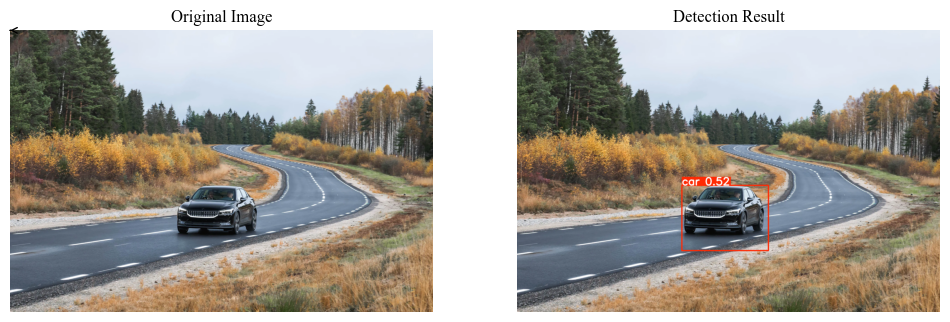

In [4]:
import matplotlib.pyplot as plt
import cv2

# Load the image
image_path = 'car.png'
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Perform detection
results = model(image_rgb)

# Get the result image
result_image = results[0].plot()

# Display the images
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original image
ax[0].imshow(image_rgb)
ax[0].set_title('Original Image', fontname='Times New Roman')
ax[0].axis('off')

# Result image
ax[1].imshow(result_image)
ax[1].set_title('Detection Result', fontname='Times New Roman')
ax[1].axis('off')

# Add an arrow between the images
arrow_props = dict(facecolor='black', arrowstyle='->')
fig.text(0.5, 0.5, '', ha='center', va='center', fontsize=12, fontname='Times New Roman')
ax[0].annotate('', xy=(0.45, 0.5), xytext=(0.55, 0.5), arrowprops=arrow_props)

plt.show()



0: 384x640 1 car, 69.2ms
Speed: 3.0ms preprocess, 69.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 74.7ms
Speed: 1.0ms preprocess, 74.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 61.8ms
Speed: 1.0ms preprocess, 61.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 66.7ms
Speed: 2.0ms preprocess, 66.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 1 train, 72.9ms
Speed: 1.0ms preprocess, 72.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 62.3ms
Speed: 2.0ms preprocess, 62.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 62.8ms
Speed: 1.0ms preprocess, 62.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 car, 78.2ms
Speed: 2.0ms preprocess, 78.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 38

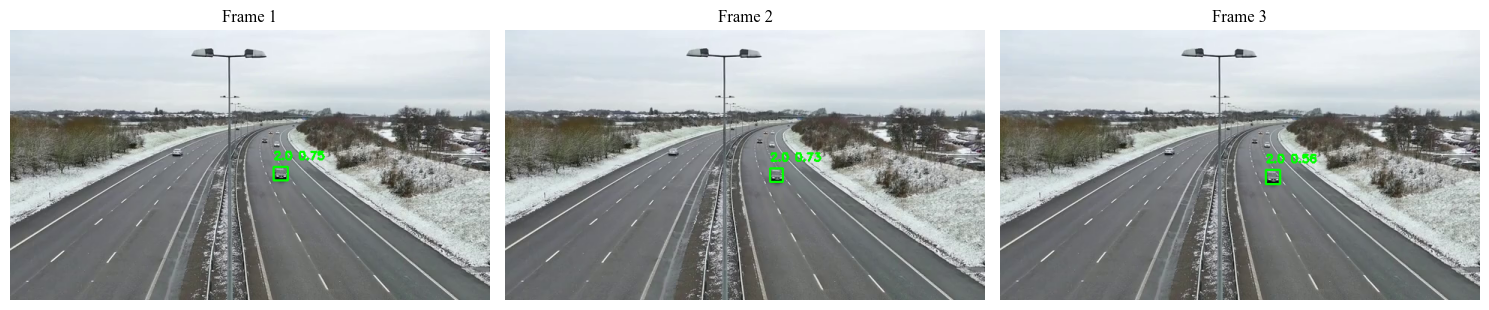

In [10]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the YOLOv8 model
model = YOLO("yolov8n.pt")

# Define the video path
video_path = 'tests/highway.mp4'
cap = cv2.VideoCapture(video_path)

# Define the confidence threshold
confidence_threshold = 0.5

# Create a list to store frames with detections
detected_frames = []
# Process the first 10 frames of the video
frame_count = 0
while cap.isOpened() and frame_count < 10:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform detection
    results = model(frame_rgb)

    # Filter results based on confidence threshold
    filtered_boxes = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            if box.conf > confidence_threshold:
                filtered_boxes.append(box)

    # Visualize the results
    for box in filtered_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        label = f"{box.cls.item()} {box.conf.item():.2f}"
        cv2.rectangle(frame_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(frame_rgb, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Append the frame to the list
    detected_frames.append(frame_rgb)
    frame_count += 1

cap.release()

# Plot the first few frames with detections
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(detected_frames[i])
    ax.axis('off')
    ax.set_title(f'Frame {i+1}', fontname='Times New Roman')

plt.tight_layout()
plt.show()


In [25]:
import numpy as np

In [26]:
# Define the video path
video_path = 'tests/highway.mp4'
cap = cv2.VideoCapture(video_path)

0: 384x640 1 car, 117.1ms
Speed: 2.0ms preprocess, 117.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


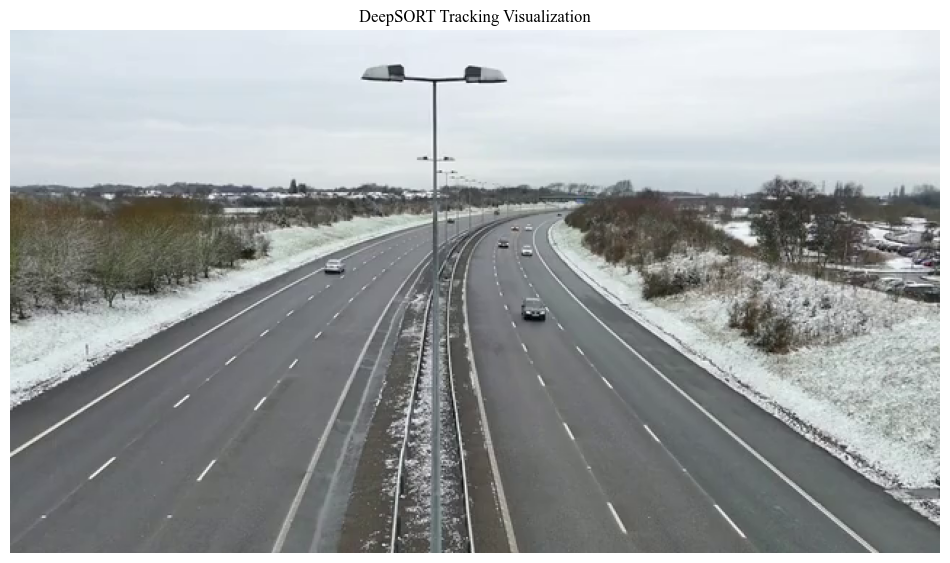

In [28]:
import matplotlib.patches as patches

# Create a figure and axis for visualization
fig, ax = plt.subplots(1, figsize=(12, 8))

# Read the first frame from the video
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()

if ret:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Perform detection on the first frame
    results = model(frame_rgb)

    # Filter results based on confidence threshold
    filtered_boxes = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            if box.conf > confidence_threshold:
                filtered_boxes.append(box)

    # Update the tracker with the filtered boxes
    bboxes_xywh = [box.xywh[0].cpu().numpy() for box in filtered_boxes]
    confidences = [box.conf.item() for box in filtered_boxes]
    tracks = tracker.update(np.array(bboxes_xywh), np.array(confidences), frame_rgb, frame_rgb)

    # Visualize the results
    for track in tracker.tracker.tracks:
        if not track.is_confirmed() or track.time_since_update > 1:
            continue

        bbox = track.to_tlbr()  # Get bounding box coordinates in (x1, y1, x2, y2) format
        track_id = track.track_id

        # Draw bounding box
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        # Draw track ID
        ax.text(bbox[0], bbox[1] - 10, f"ID: {track_id}", color='red', fontsize=12, fontweight='bold')

    # Display the frame
    ax.imshow(frame_rgb)
    ax.set_title('DeepSORT Tracking Visualization', fontname='Times New Roman')
    ax.axis('off')

    plt.show()
else:
    print("Failed to read the frame from the video.")

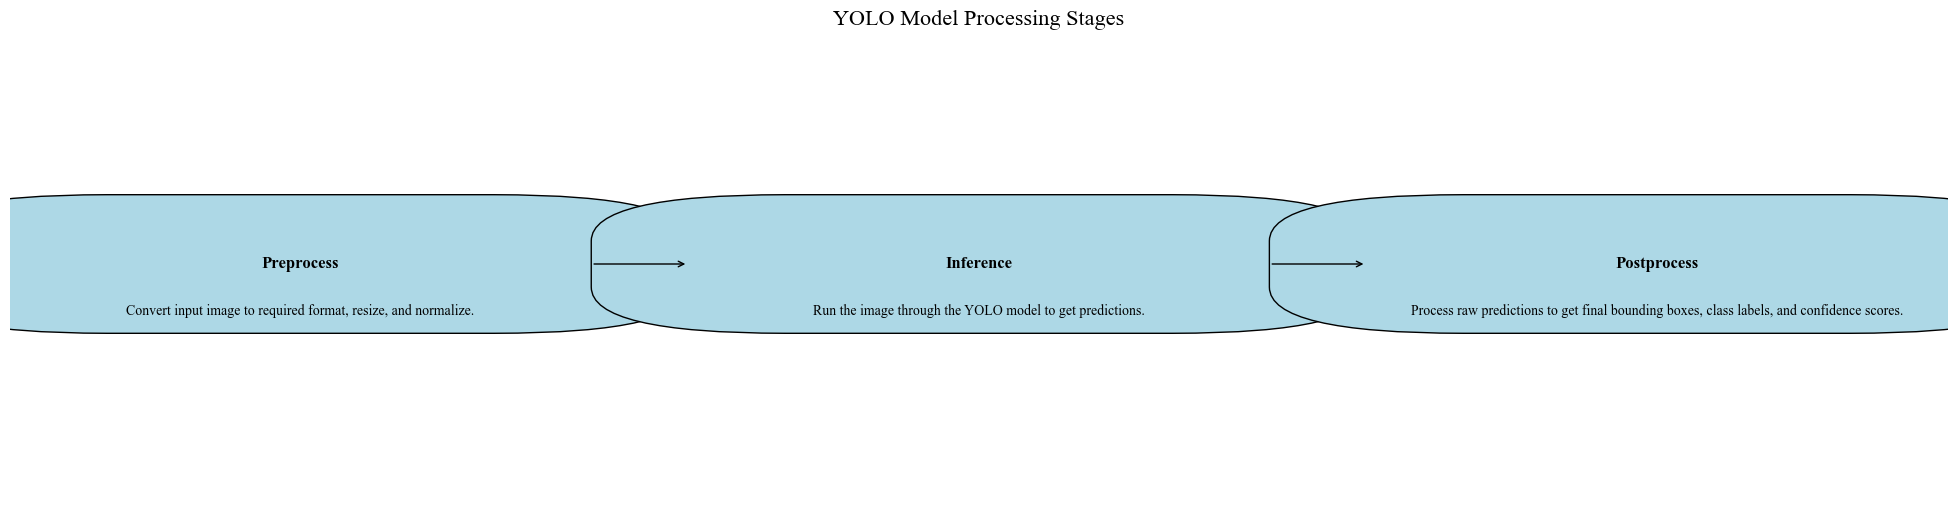

In [43]:
# Create a figure and axis for the flowchart
fig, ax = plt.subplots(figsize=(25, 6))  # Increase the figure width

# Adjust positions and box sizes to avoid overlap
positions = {
    'Preprocess': (0.15, 0.5),
    'Inference': (0.5, 0.5),
    'Postprocess': (0.85, 0.5)
}

# Descriptions for each stage
descriptions = {
    'Preprocess': 'Convert input image to required format, resize, and normalize.',
    'Inference': 'Run the image through the YOLO model to get predictions.',
    'Postprocess': 'Process raw predictions to get final bounding boxes, class labels, and confidence scores.'
}

for stage, pos in positions.items():
    ax.add_patch(patches.FancyBboxPatch(
        (pos[0] - 0.1, pos[1] - 0.05), 0.2, 0.1,
        boxstyle="round,pad=0.1", edgecolor='black', facecolor='lightblue'
    ))
    ax.text(pos[0], pos[1], stage, ha='center', va='center', fontsize=12, fontname='Times New Roman', weight='bold')
    ax.text(pos[0], pos[1] - 0.1, descriptions[stage], ha='center', va='center', fontsize=10, fontname='Times New Roman', wrap=True)

# Add arrows between the stages
ax.annotate('', xy=(positions['Inference'][0] - 0.15, positions['Inference'][1]), xytext=(positions['Preprocess'][0] + 0.15, positions['Preprocess'][1]), arrowprops=arrow_props)
ax.annotate('', xy=(positions['Postprocess'][0] - 0.15, positions['Postprocess'][1]), xytext=(positions['Inference'][0] + 0.15, positions['Inference'][1]), arrowprops=arrow_props)

# Add title to the plot
ax.set_title('YOLO Model Processing Stages', fontsize=16, fontname='Times New Roman')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')
plt.show()


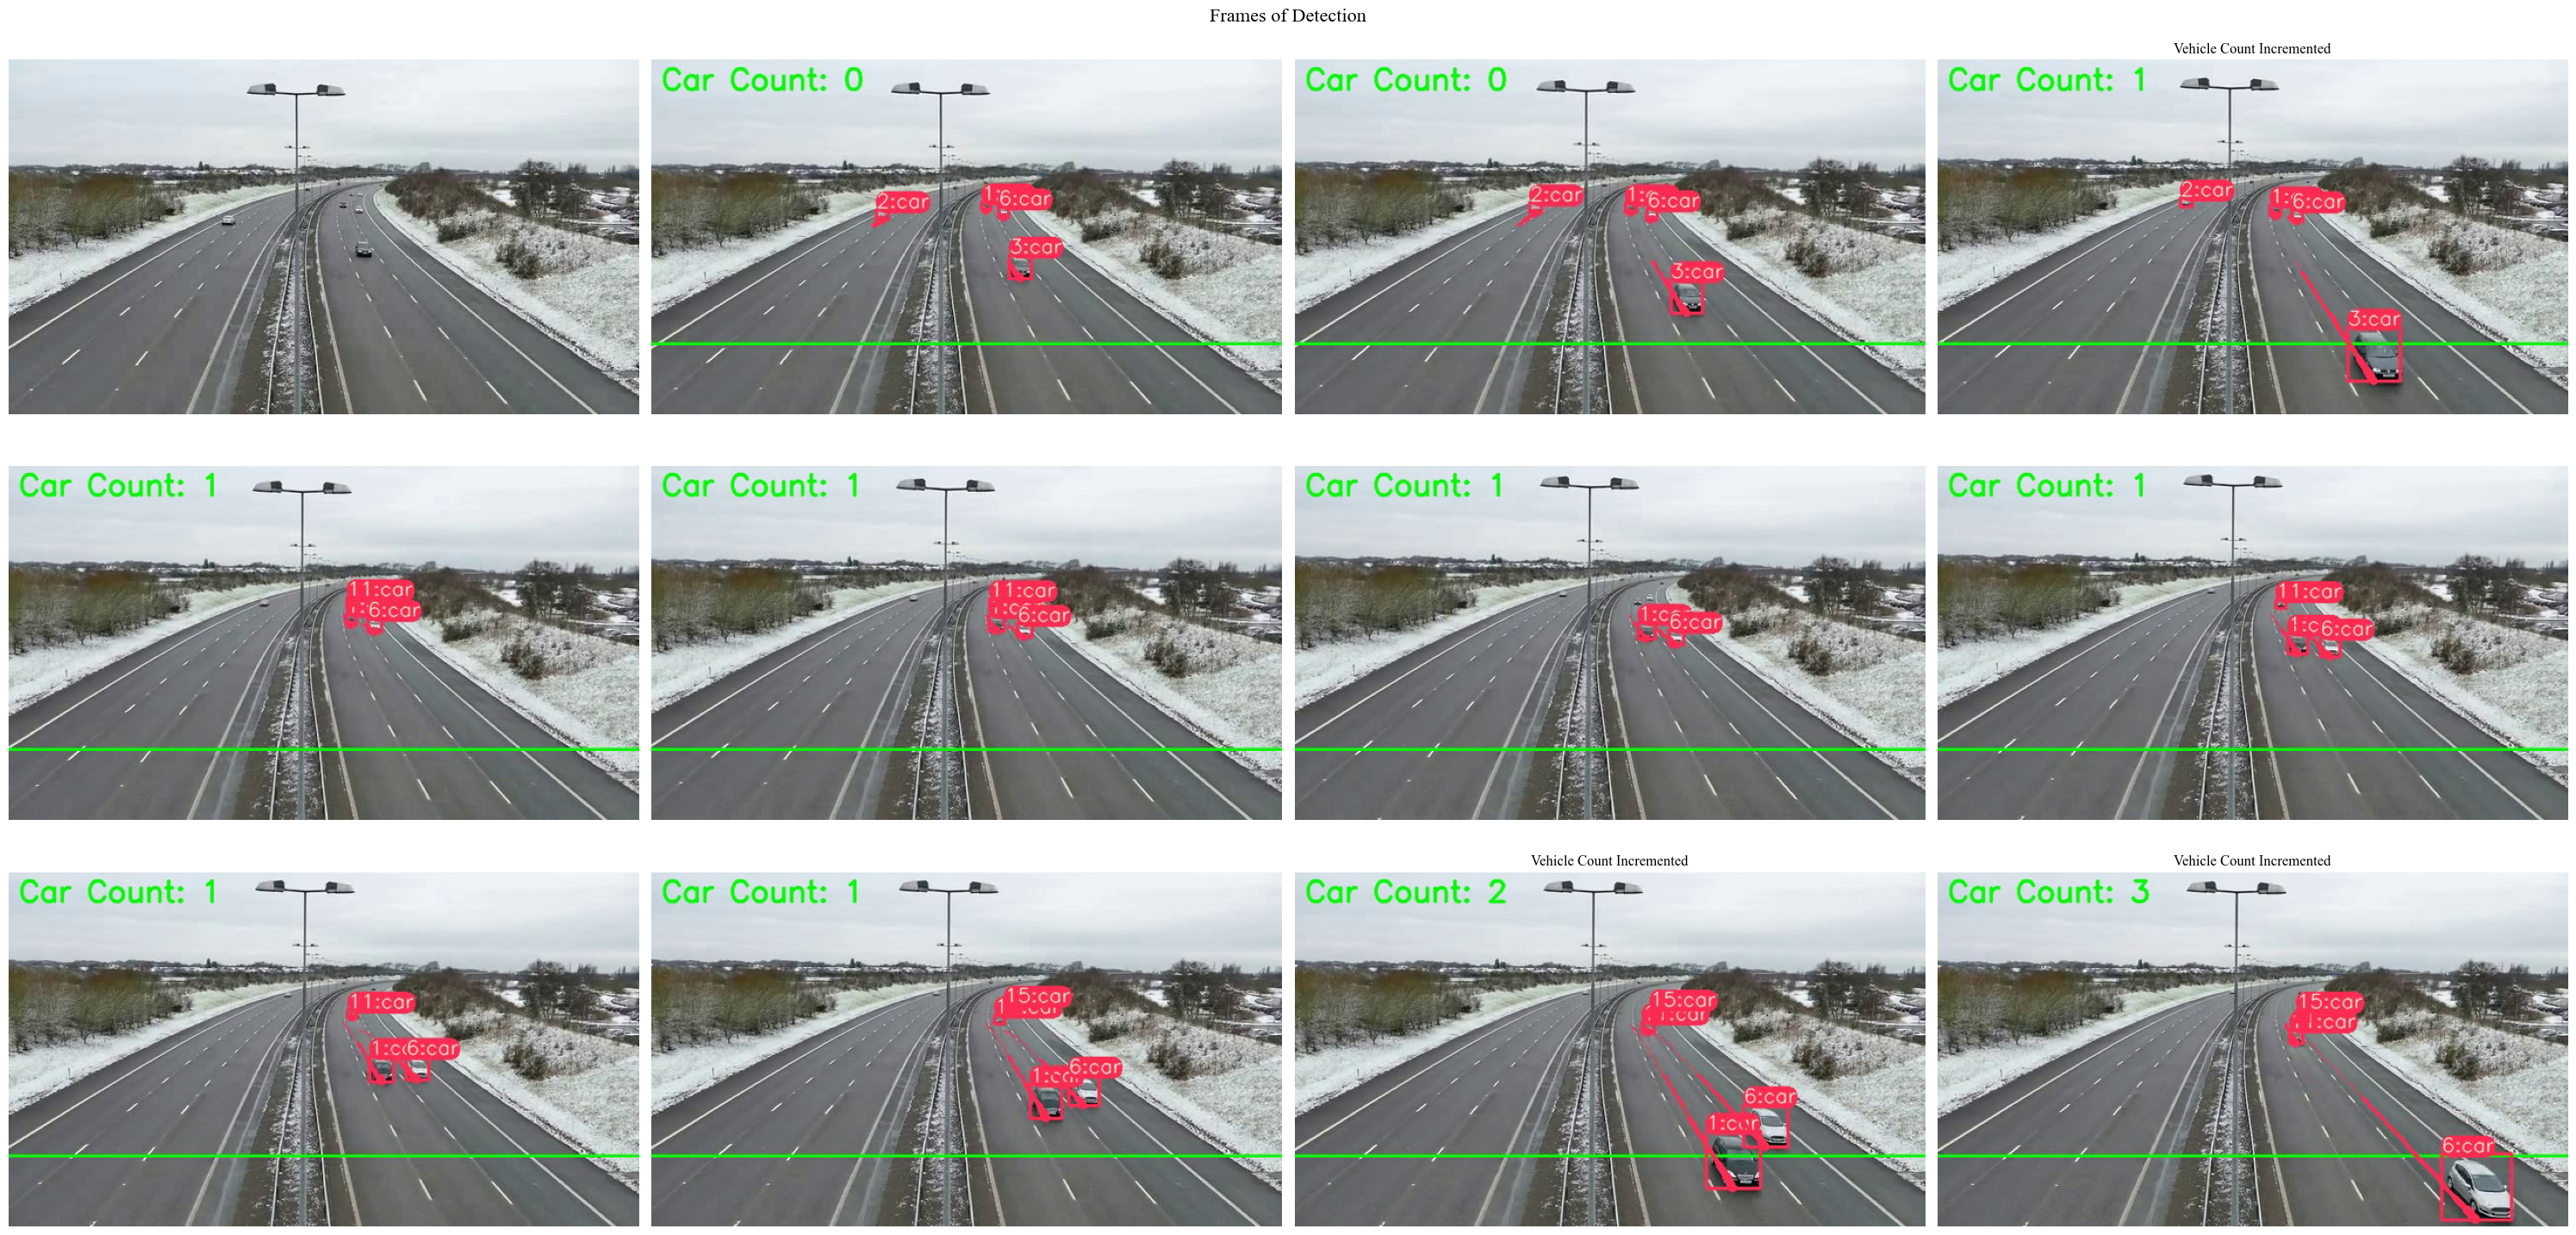

In [67]:
import cv2
import matplotlib.pyplot as plt

# Define the video path
video_path = 'runs/detect/train13/highway.mp4'
cap = cv2.VideoCapture(video_path)

# Create a list to store frames
frames = []

# Read the first 18 frames from the video, skipping every other frame
frame_count = 0
skip_frames = 8  # Number of frames to skip
while cap.isOpened() and frame_count < 200:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_count % skip_frames == 0:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    frame_count += 1

cap.release()

# Plot the frames in a 6x3 grid
fig, axes = plt.subplots(3, 4, figsize=(30, 15))
fig.suptitle('Frames of Detection', fontsize=16, fontname='Times New Roman')  # Set the whole plot title
for i, ax in enumerate(axes.flat):
    if i < len(frames):
        ax.imshow(frames[i])
        ax.axis('off')
        if i in [3, 10, 11]:  # Frames 4, 11, 12 (0-indexed)
            ax.set_title(f'Vehicle Count Incremented', fontname='Times New Roman')  # Increment title count by 1
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [68]:
import pandas as pd

In [70]:
results = pd.read_csv('results.csv')

In [71]:
results.head()

epoch        train/box_loss        train/cls_loss  \
0                     0                3.7071                2.9695   
1                     1                2.7243                2.1578   
2                     2                2.3788                1.8426   
3                     3                2.1729                1.6752   
4                     4                2.0152                1.5404   

         train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
0                3.2853               0.05762               0.10846   
1                2.3764               0.30842               0.23601   
2                2.0341               0.37544               0.24132   
3                1.8585               0.53071               0.36116   
4                1.7470               0.47070               0.32410   

       metrics/mAP50(B)   metrics/mAP50-95(B)          val/box_loss  \
0               0.02499               0.00760                     0   
1               0.18628               0.06500                     0   
2               0.20871               0.05677                     0   
3               0.36821               0.10445                     0   
4               0.28139               0.06537                     0   

              val/cls_loss          val/dfl_loss                lr/pg0  \
0                      inf                     0              0.070091   
1                      inf                     0              0.039960   
2                      inf                     0              0.009696   
3                      inf                     0              0.009406   
4                      inf                     0              0.009406   

                 lr/pg1                lr/pg2  
0              0.003323              0.003323  
1              0.006525              0.006525  
2              0.009594              0.009594  
3              0.009406              0.009406  
4              0.009406              0.009406

In [72]:
import matplotlib.pyplot as plt

# Extract data from the results dataframe
epochs = results['epoch']
train_box_loss = results['train/box_loss']
train_cls_loss = results['train/cls_loss']
train_dfl_loss = results['train/dfl_loss']
val_box_loss = results['val/box_loss']
val_cls_loss = results['val/cls_loss'].replace('inf', float('inf'))  # Replace 'inf' with float('inf')
val_dfl_loss = results['val/dfl_loss']
precision = results['metrics/precision(B)']
recall = results['metrics/recall(B)']
map50 = results['metrics/mAP50(B)']
map50_95 = results['metrics/mAP50-95(B)']

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_box_loss, label='Train Box Loss')
plt.plot(epochs, train_cls_loss, label='Train Class Loss')
plt.plot(epochs, train_dfl_loss, label='Train DFL Loss')
plt.plot(epochs, val_box_loss, label='Validation Box Loss')
plt.plot(epochs, val_cls_loss, label='Validation Class Loss')
plt.plot(epochs, val_dfl_loss, label='Validation DFL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()

# Plot metrics
plt.figure(figsize=(12, 6))
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, map50, label='mAP@50')
plt.plot(epochs, map50_95, label='mAP@50-95')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Metrics over Epochs')
plt.legend()
plt.grid(True)
plt.show()

KeyError: 'epoch'

In [2]:
from ultralytics import YOLO, checks

checks()

Ultralytics YOLOv8.0.43  Python-3.12.6 torch-2.5.1+cpu CPU
Setup complete  (12 CPUs, 7.7 GB RAM, 218.3/237.5 GB disk)


In [3]:
from ultralytics.nn.tasks import PoseModel

ImportError: cannot import name 'PoseModel' from 'ultralytics.nn.tasks' (C:\Users\PMLS\AppData\Roaming\Python\Python312\site-packages\ultralytics\nn\tasks.py)

In [1]:
from ultralytics import YOLO
model = YOLO('yolov8n-pose.pt')  # Load the pose model directly


WARNING  Different global settings detected, resetting to defaults. This may be due to an ultralytics package update. View and update your global settings directly in C:\Users\PMLS\AppData\Roaming\Ultralytics\settings.yaml
c:\Users\PMLS\anaconda3\envs\env_tracking\lib\site-packages\ultralytics\nn\tasks.py:341: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start 

AttributeError: Can't get attribute 'PoseModel' on <module 'ultralytics.nn.tasks' from 'c:\\Users\\PMLS\\anaconda3\\envs\\env_tracking\\lib\\site-packages\\ultralytics\\nn\\tasks.py'>